<a href="https://colab.research.google.com/github/pankajrawat9075/CS6910_Assignment_1/blob/main/Copy_of_Question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import the Libraries

In [ ]:
!pip install wandb -qU

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

##Question 1

###Load Dataset

In [ ]:
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
# Split the X_train into a training set and validation set
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.1, random_state=42)

###Summarize loaded dataset

In [ ]:
print('Train: X = %s, y = %s' % (trainX.shape, trainY.shape))
print('Validation: X = %s, y = %s' % (valX.shape, valY.shape))
print('Test: X = %s, y = %s' % (testX.shape, testY.shape))

Train: X = (54000, 28, 28), y = (54000,)
Validation: X = (6000, 28, 28), y = (6000,)
Test: X = (10000, 28, 28), y = (10000,)


### Display all labels images

unique_labels = [0 1 2 3 4 5 6 7 8 9]


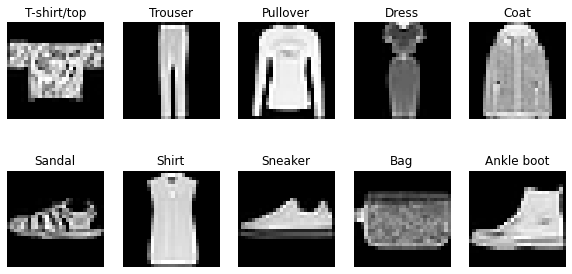

In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="CS6910_Assignment-1",
)
# Get the unique labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
unique_labels = np.unique(trainY)
print("unique_labels = %s" % (unique_labels))

# Create a subplot for each label
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
axes = axes.flatten()

# Loop through the labels and display an image for each label
for i, label in enumerate(unique_labels):
    # Get the first image with this label
    img = trainX[trainY == label][0]
    # Plot the image
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_names[label])
    axes[i].axis('off')
    

wandb.log({"plot":plt})   
# finish the wandb run, necessary in notebooks


### Data Preprocessing

In [ ]:
# Normalize the pixel values to the range [0, 1]
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

trainSize = trainY.shape[0]
testSize = testY.shape[0]

#One-Hot encoding for trainY and testY and valY
y_train = np.zeros(( 10, trainSize ))
y_val = np.zeros(( 10, 6000 ))
y_test = np.zeros(( 10, testSize ))

for i in range(0, trainSize ):
    y_train[trainY[i]][i] = 1

for i in range(6000):
    y_val[valY[i]][i] = 1

for i in range(0, testSize ):
    y_test[testY[i]][i] = 1

trainY = y_train
valY = y_val
testY = y_test

# reshape the X matrices
trainX = trainX.reshape(trainX.shape[0], 784)
valX = valX.reshape(6000, 784)
testX = testX.reshape(10000, 784)

trainX = trainX.T
valX = valX.T
testX = testX.T

In [ ]:
trainX.shape

(784, 54000)

[link text](https://)## Wand B config parameters

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values' : [2, 5, 10]
        },

        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'optimizer': {
            'values': ['adam', 'sgd']
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd', 'rmsprop']
        },
        'activation': {
            'values': ['relu', 'sigmoid', 'tanh']
        }
    }
}

##Neural network 

### Activation functions

In [ ]:
def sigmoid(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return np.multiply(s, np.subtract(1, s))

def relu( x):
    """
    Rectified Linear Unit (ReLU) activation function that avoids overflow.
    """
    return np.maximum(0, x)

def relu_deriv( x):
    """
    Derivative of the ReLU activation function that avoids overflow.
    """
    return np.where(x > 0, 1, 0)

def tanh(x):
    if x >= 0:
        return 1 - 2 / (np.exp(2*x) + 1)
    else:
        return 2 / (np.exp(-2*x) + 1) - 1

def tanh_deriv(x):
    tanh_x = tanh(x)
    return 1 - tanh_x**2

def softmax(x):
    x -= np.max(x, axis = 0)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis = 0)

### Forward Propogation

In [ ]:
def forward_prop(W, B, x, act_func = 'sigmoid'):

    '''
    Returns
      -------

      output: numpy array
          contains the output probabilities for each class and each data sample after 1 pass
      A: numpy array
          contains all activations
      H: numpy array
          consists all pre-activations
      --------
    '''
    L = W.shape[0]+1
    A = [None] * (L - 1)

    H = [None] * (L - 1)
    Y_ = [None]

    A[0] = B[0].reshape(-1, 1) + np.matmul(W[0], x) # for the first pre-activation layer x is the input 

    for i in range(0, L-2):
        if act_func == "sigmoid":
            H[i] = sigmoid(A[i])         # computing the activation layer 

        elif act_func == "relu":
            H[i] = relu(A[i]) 

        elif act_func == "tanh":
            H[i] = tanh(A[i]) 

        A[i+1] = B[i+1].reshape(-1, 1) + np.matmul(W[i+1], H[i])

    Y_ = softmax(A[L-2])

    return A, H, Y_


### Backward Propogation

In [ ]:
def back_prop(W, B,  x, y, A, H, Y_, act_func):
    L = W.shape[0]+1

    del_A,  del_H = A,  H  # creating gradient variables
    del_W = [None] * (L-1)
    del_B = [None] * (L-1)

    del_A[-1] = -(y - Y_)

    for i in range(L-2, 0, -1):
        del_W[i] = np.matmul(del_A[i],  np.transpose( H[i-1]))   # compute gradients with respect to weihts and bias
        del_B[i] = del_A[i]
        del_B[i] = np.array(np.sum(del_B[i], axis = 1))

        del_H[i-1] = np.matmul(np.transpose(W[i]), del_A[i])

        if act_func == "sigmoid":
            del_A[i-1] = del_H[i-1] * sigmoid_deriv(A[i-1])
        elif act_func == "relu":
            del_A[i-1] = del_H[i-1] * relu_deriv(A[i-1])
        elif act_func == "tanh":
            del_A[i-1] = del_H[i-1] * tanh_deriv(A[i-1])  

    del_W[0] = np.matmul(del_A[0] , np.transpose(x))  # compute gradients with respect to weihts and bias
    del_B[0] = del_A[0]

    del_B[0] = np.array(np.sum(del_B[0], axis = 1))


    return del_W, del_B

### Training the network

In [ ]:
def train(layers, X, Y, epochs, alpha, activation_func, optimizer = "sgd", batch_size = 512 ):   
    """
    alpha : learning rate

    """
    L = len(layers) # no. of layers

    # initialize the weights and biases
    W = []
    B = []
    u_b, u_w, v_w, v_b = [], [], [], []

    for i in range(1, L):
        w = np.random.randn(layers[i], layers[i-1])
        temp_w = np.zeros((layers[i], layers[i-1]))
        b = np.random.randn(layers[i])           # b is bias vector
        temp_b = np.zeros((layers[i]))
        W.append(w)
        B.append(b)
        u_w.append(temp_w)
        v_w.append(temp_w)
        u_b.append(temp_b)
        v_b.append(temp_b)

    W = np.array(W)
    B = np.array(B)
    u_w = np.array(u_w)
    v_w = np.array(v_w)
    u_b = np.array(u_b)
    v_b = np.array(v_b)

    # define things for nag optimizer
    
    beta = 0.9
    eps = 0.0001

    for epoch in range(epochs):
        for i in range(0, X.shape[1], batch_size):
            batch_count = batch_size

            if i + batch_size > X.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X.shape[1] - i + 1

            

            if optimizer == 'sgd':

                A, H, Y_ = forward_prop(W, B, X[:, i:i+batch_count], activation_func)
                del_w, del_b = back_prop(W, B, X[:, i:i+batch_count], Y[:, i:i+batch_count], A, H, Y_, activation_func)

                W, B = update_parms_sgd(W, B, alpha, del_w, del_b)

            elif optimizer == 'momentum':
                A, H, Y_ = forward_prop(W, B, X[:, i:i+batch_count], activation_func)
                del_w, del_b = back_prop(W, B, X[:, i:i+batch_count], Y[:, i:i+batch_count], A, H, Y_, activation_func) # compute the gradient at the lookahead

                u_w = beta * u_w + del_w
                u_b = beta * u_b + del_b
                W, B = update_parms_momentum(W, B, alpha, u_w, u_b)


            elif optimizer == 'nag':

                A, H, Y_ = forward_prop(W - beta * u_w, B - alpha * u_b, X[:, i:i+batch_count], activation_func)
                del_w, del_b = back_prop(W - beta * u_w, B - alpha * u_b, X[:, i:i+batch_count], Y[:, i:i+batch_count], A, H, Y_, activation_func) # compute the gradient at the lookahead

                u_w = beta * u_w + del_w
                u_b = beta * u_b + del_b
                
                W, B = update_parms_sgd(alpha, u_w, u_b)

            elif optimizer == 'RMSprop':

                A, H, Y_ = forward_prop(W, B, X[:, i:i+batch_count], activation_func)
                del_w, del_b = back_prop(W, B, X[:, i:i+batch_count], Y[:, i:i+batch_count], A, H, Y_, activation_func) # compute the gradient at the lookahead

                u_w = beta * u_w + (1-beta)*del_w**2
                u_b = beta * u_b + (1-beta)*del_b**2
                
                W, B = update_parms_RMSprop(alpha, u_w, u_b, del_w, del_b, eps)

    return W, B


### Optimizers

In [ ]:
def update_parms_sgd(W, B, alpha, del_w, del_b):
    W = W - alpha * np.array(np.array(del_w))
    B = B - alpha * np.array(del_b)
    return W, B

def update_parms_nag(W, B, alpha, u_w, u_b):
    W = W - alpha * np.array(np.array(u_w))
    B = B - alpha * np.array(u_b)
    return W, B

def update_parms_momentum(W, B, alpha, u_w, u_b):
    W = W - alpha * np.array(np.array(u_w))
    B = B - alpha * np.array(u_b)
    return W, B 

def update_parms_RMSprop(W, B, alpha, u_w, u_b, del_w, del_b, eps):
    W = W - alpha * np.array(np.array(del_w)) / (np.sqrt(u_w) + eps)
    B = B - alpha * np.array(del_b) / (np.sqrt(u_b) + eps)
    return W, B 



### Predictions and Evaluations

In [ ]:
def predict(X, W, B, act_fun):
    '''
    forward propagate once and calculate labels

    '''
    _, _, output = forward_prop(W, B, X, act_fun)
    predictions = np.argmax(output, axis=0)
    return predictions

def evaluate(X_train, y_train, X_test, y_test, W, B, activation_f):
    '''
    print train,test accuracies and the classification report using sklearn

    '''
    y_train = np.argmax(y_train, axis=0)
    train_predictions = predict(X_train, W, B, activation_f)
    y_test = np.argmax(y_test, axis=0)
    test_predictions = predict(X_test, W, B, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100, 3)))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100, 3)))

    return train_predictions, test_predictions

## Running the Experiments

### Train

In [ ]:
W, B = train([28*28, 128, 128, 10], trainX, trainY, epochs=10, alpha = 0.00001, activation_func="sigmoid", optimizer="sgd", batch_size=16)

<ipython-input-40-7c8a877c911b>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  W = np.array(W)
<ipython-input-40-7c8a877c911b>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)
<ipython-input-40-7c8a877c911b>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  u_w = np.array(u_w)
<ipython-input-40-7c8a877c911b>:28: 

### Test

In [ ]:
evaluate(trainX, trainY, testX, testY, W, B, "sigmoid")

Training accuracy = 47.959 %
Test accuracy = 46.9 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.49      0.52      0.51      1000
           1       0.67      0.64      0.66      1000
           2       0.38      0.37      0.38      1000
           3       0.52      0.53      0.53      1000
           4       0.39      0.47      0.42      1000
           5       0.42      0.38      0.40      1000
           6       0.24      0.21      0.22      1000
           7       0.59      0.60      0.59      1000
           8       0.38      0.35      0.37      1000
           9       0.57      0.63      0.60      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



(array([7, 2, 8, ..., 2, 2, 0]), array([9, 4, 3, ..., 5, 1, 9]))